## Setup
Install and import dependencies and set random state seed value.

In [1]:
%pip install pyreadr

%pip install scikit-learn
%pip install xgboost

%pip install -U matplotlib
%pip install typeguard

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# library to check function types of imported modules
from typeguard import install_import_hook

# custom functions for plotting, etc.
with install_import_hook('custom_ml_plots'):
    import custom_ml_plots as cmp
with install_import_hook('custom_dataset_tools'):
    import custom_dataset_tools as cdt
with install_import_hook('basic_ml_operations'):
    import basic_ml_operations as bmo

# data import
import pyreadr

# basic math libraries
import pandas as pd

# global parameters
RANDOM_STATE = 42
TEST_SET_PORTION = 0.15
CV_SET_PORTION = 0.15
TOP_LINE_THRESH = 0.8

## Train model with default values

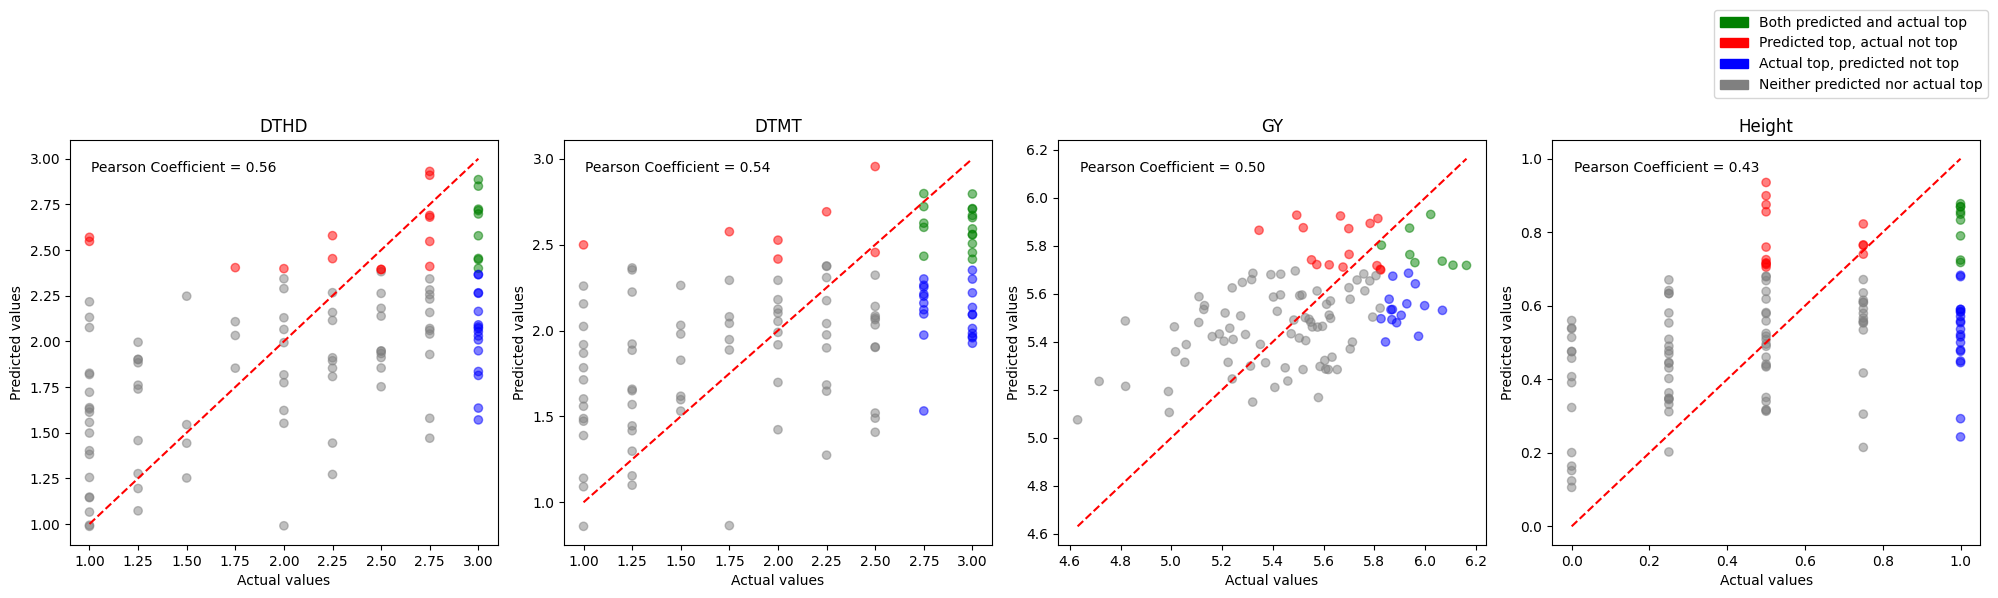

In [2]:
# import dataset
eyt1 = pyreadr.read_r('./data/eyt1.RData')

# extract training example labels
eyt1_y = eyt1['Pheno_Disc_Env1']

# sort by ID, drop unneeded column describing planting environment
eyt1_y = eyt1_y.sort_values(by=eyt1_y.columns[0])
eyt1_y = eyt1_y.drop('Env', axis=1)

# extract gene IDs (row labels) from first column. We save other column headers in a 
# list (these are the values we attempt to predict)
gene_labels, eyt1_y = cdt.seperate_ID(eyt1_y)
target_labels = eyt1_y.columns

# check missing values
cdt.assert_no_bad_values(eyt1_y)

# each seed was planted in 4 different environments, but we don't care about environmental differences
# so we take the average of every group of four rows to reduce the dataset to 1/4 its original size
gene_labels = gene_labels[::4]
eyt1_y = cdt.avg_rows(eyt1_y, 4)

# extract feature matrix
eyt1_X = eyt1['Geno_Env1']

# scale feature matrix
scaler, eyt1_X = bmo.scale(eyt1_X)

# split feature matrix into training, CV & test sets
X_train, y_train, X_CV, y_CV, X_test, y_test = bmo.split(eyt1_X, eyt1_y, CV_SET_PORTION, TEST_SET_PORTION, RANDOM_STATE)
svr = bmo.train_SVR(X_train, y_train)

# predict, identify top lines and plot
y_pred = svr.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=target_labels)
y_pred_top = cdt.classify_top(y_pred, TOP_LINE_THRESH)
y_test_top = cdt.classify_top(y_test, TOP_LINE_THRESH)
cmp.plot_predictions_vs_actuals(y_pred, y_test, y_pred_top, y_test_top)

## Grid search

In [5]:
# C values and kernels to try combos of
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# perform the grid search with SVR models
model_grid = bmo.grid_search(X_train, y_train, param_grid, bmo.train_SVR)
print(model_grid)

                                                         Model
C    kernel                                                   
0.1  linear  MultiOutputRegressor(estimator=SVR(C=0.1, kern...
     rbf            MultiOutputRegressor(estimator=SVR(C=0.1))
1.0  linear  MultiOutputRegressor(estimator=SVR(C=1, kernel...
     rbf              MultiOutputRegressor(estimator=SVR(C=1))
10.0 linear  MultiOutputRegressor(estimator=SVR(C=10, kerne...
     rbf             MultiOutputRegressor(estimator=SVR(C=10))


In [ ]:
# why are there a fixed number of values for properties other than GY